In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("karimabdulnabi/fruit-classification10-class")

print("Path to dataset files:", path)
print("Contents:", os.listdir(path))

# Adjust paths to include the 'MY_data' subdirectory
train_path = os.path.join(path, "MY_data", "train")
test_path = os.path.join(path, "MY_data", "test")

print("Training subfolders:", os.listdir(train_path))
print("Testing subfolders:", os.listdir(test_path))

100%|██████████| 29.2M/29.2M [00:02<00:00, 12.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/karimabdulnabi/fruit-classification10-class/versions/1
Contents: ['MY_data']
Training subfolders: ['Banana', 'strawberries', 'Apple', 'kiwi', 'avocado', 'orange', 'watermelon', 'mango', 'pinenapple', 'cherry']
Testing subfolders: ['banana', 'kiwi', 'avocado', 'stawberries', 'apple', 'orange', 'watermelon', 'mango', 'pinenapple', 'cherry']


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
  )

train_gen = datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    subset='validation',
    shuffle=False
)

print("Class labels:", train_gen.class_indices)

Found 1841 images belonging to 10 classes.
Found 460 images belonging to 10 classes.
Class labels: {'Apple': 0, 'Banana': 1, 'avocado': 2, 'cherry': 3, 'kiwi': 4, 'mango': 5, 'orange': 6, 'pinenapple': 7, 'strawberries': 8, 'watermelon': 9}


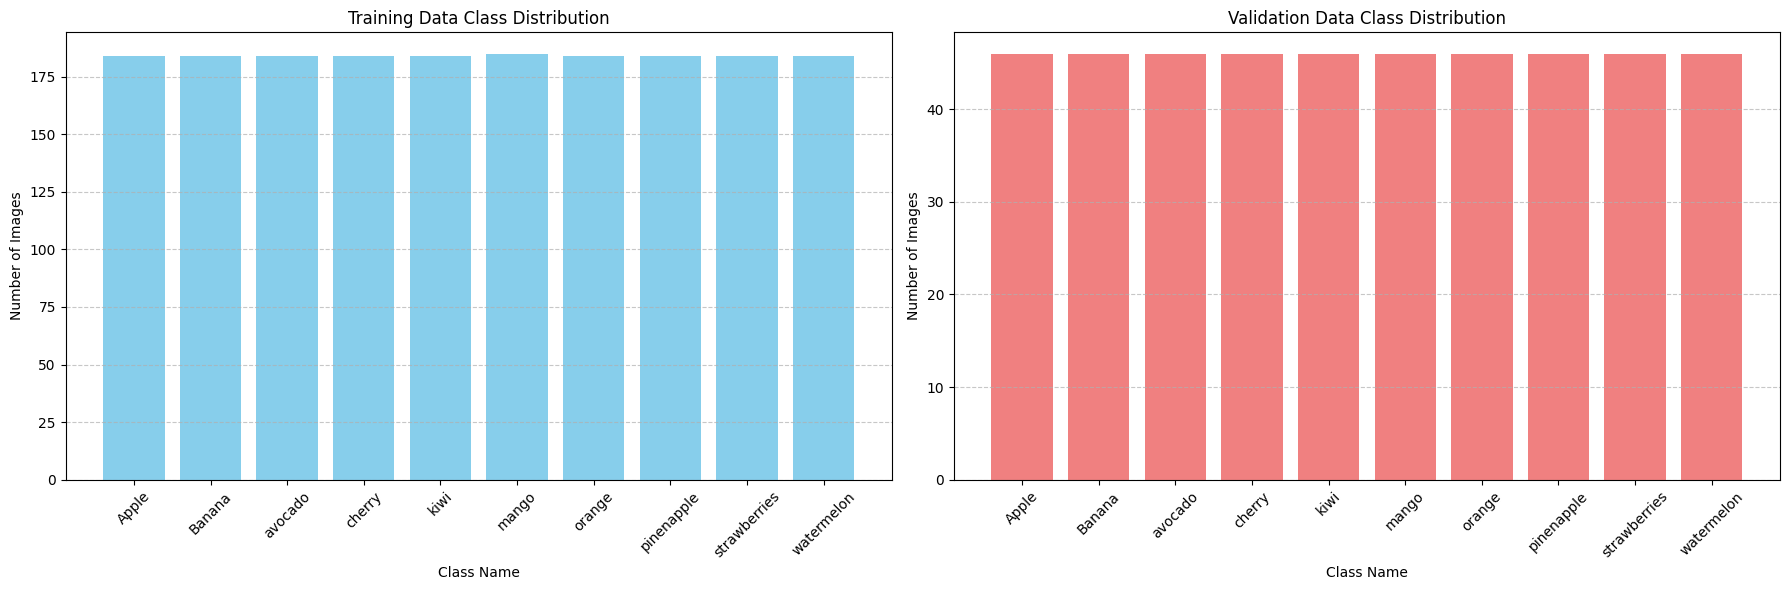


Training Class Distribution:
  Apple: 184 images
  Banana: 184 images
  avocado: 184 images
  cherry: 184 images
  kiwi: 184 images
  mango: 185 images
  orange: 184 images
  pinenapple: 184 images
  strawberries: 184 images
  watermelon: 184 images

Validation Class Distribution:
  Apple: 46 images
  Banana: 46 images
  avocado: 46 images
  cherry: 46 images
  kiwi: 46 images
  mango: 46 images
  orange: 46 images
  pinenapple: 46 images
  strawberries: 46 images
  watermelon: 46 images


In [9]:

import collections
import matplotlib.pyplot as plt
import numpy as np

# Get class distribution for training data
train_class_counts = collections.Counter(train_gen.classes)
train_labels = [train_gen.class_indices[str(i)] for i in sorted(train_gen.class_indices, key=train_gen.class_indices.get)]

# Get class distribution for validation data
val_class_counts = collections.Counter(val_gen.classes)
val_labels = [val_gen.class_indices[str(i)] for i in sorted(val_gen.class_indices, key=val_gen.class_indices.get)]

# Mapping class to index
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}

train_class_names = [idx_to_class[idx] for idx in train_class_counts.keys()]
train_counts = list(train_class_counts.values())

val_class_names = [idx_to_class[idx] for idx in val_class_counts.keys()]
val_counts = list(val_class_counts.values())

train_sorted_indices = np.argsort(train_class_names)
train_class_names_sorted = np.array(train_class_names)[train_sorted_indices]
train_counts_sorted = np.array(train_counts)[train_sorted_indices]

val_sorted_indices = np.argsort(val_class_names)
val_class_names_sorted = np.array(val_class_names)[val_sorted_indices]
val_counts_sorted = np.array(val_counts)[val_sorted_indices]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Training data distribution
axes[0].bar(train_class_names_sorted, train_counts_sorted, color='skyblue')
axes[0].set_title('Training Data Class Distribution')
axes[0].set_xlabel('Class Name')
axes[0].set_ylabel('Number of Images')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Validation data distribution
axes[1].bar(val_class_names_sorted, val_counts_sorted, color='lightcoral')
axes[1].set_title('Validation Data Class Distribution')
axes[1].set_xlabel('Class Name')
axes[1].set_ylabel('Number of Images')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("\nTraining Class Distribution:")
for class_name, count in zip(train_class_names_sorted, train_counts_sorted):
    print(f"  {class_name}: {count} images")

print("\nValidation Class Distribution:")
for class_name, count in zip(val_class_names_sorted, val_counts_sorted):
    print(f"  {class_name}: {count} images")

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (128, 128, 3)

# MobileNetV2 expects 3 channel input
base_model = MobileNetV2(input_shape=(input_shape), include_top=False, weights='imagenet')
base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape)

x = base_model(inputs, training=False)

# Add new classification layers on top
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.7)(x)
outputs = layers.Dense(len(train_gen.class_indices), activation='softmax')(x)

transfer_model = models.Model(inputs, outputs)

transfer_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

transfer_model.summary()

#Dataset is small, Limit
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_transfer = transfer_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop]
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 417ms/step - accuracy: 0.2463 - loss: 2.4442 - val_accuracy: 0.7978 - val_loss: 0.8270
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - accuracy: 0.6068 - loss: 1.1604 - val_accuracy: 0.8652 - val_loss: 0.5383
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step - accuracy: 0.6910 - loss: 0.9251 - val_accuracy: 0.8587 - val_loss: 0.4549
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 0.7344 - loss: 0.8016 - val_accuracy: 0.8717 - val_loss: 0.3901
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step - accuracy: 0.7886 - loss: 0.6583 - val_accuracy: 0.8870 - val_loss: 0.3626
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - accuracy: 0.7753 - loss: 0.6710 - val_accuracy: 0.9000 - val_loss: 0.3419
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - accuracy: 0.8278 - loss: 0.5122 - val_accuracy: 0.8739 - val_loss: 0.3558
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 202ms/step - accuracy: 0.8228 - loss: 0.5201 - val_accu

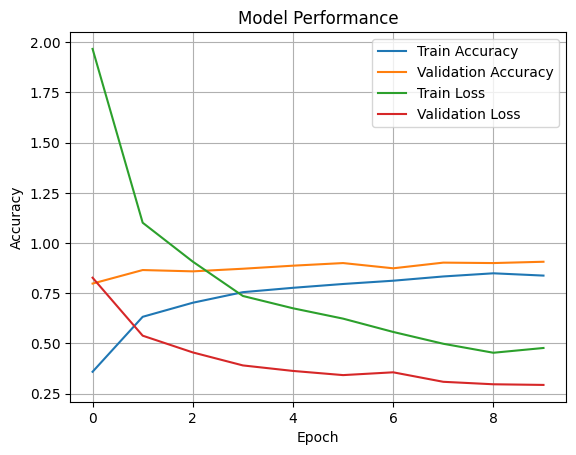

In [16]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_transfer.history['accuracy'], label='Train Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_transfer.history['loss'], label='Train Loss')
plt.plot(history_transfer.history['val_loss'], label='Validation Loss')
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 426ms/step
Classification Report:
              precision    recall  f1-score   support

       Apple       0.90      0.93      0.91        46
      Banana       0.94      0.96      0.95        46
     avocado       0.84      0.91      0.88        46
      cherry       0.88      0.96      0.92        46
        kiwi       0.93      0.80      0.86        46
       mango       0.82      0.70      0.75        46
      orange       0.83      0.93      0.88        46
  pinenapple       0.98      0.98      0.98        46
strawberries       0.98      0.91      0.94        46
  watermelon       0.93      0.91      0.92        46

    accuracy                           0.90       460
   macro avg       0.90      0.90      0.90       460
weighted avg       0.90      0.90      0.90       460



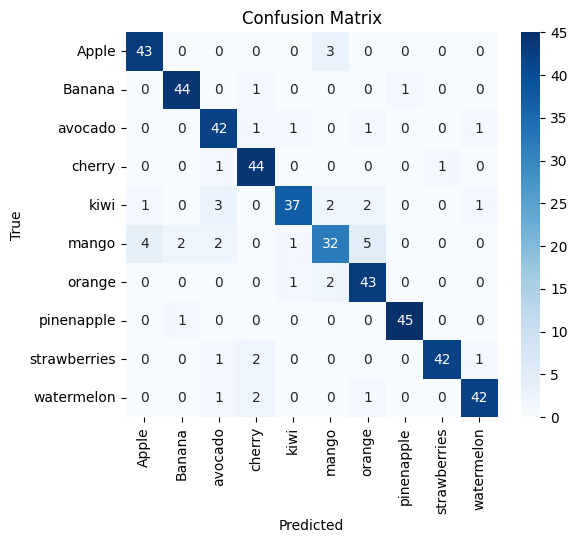

In [17]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = transfer_model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes
labels = list(val_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Press 'Stop' in Colab or interrupt the kernel to stop.


<IPython.core.display.Javascript object>

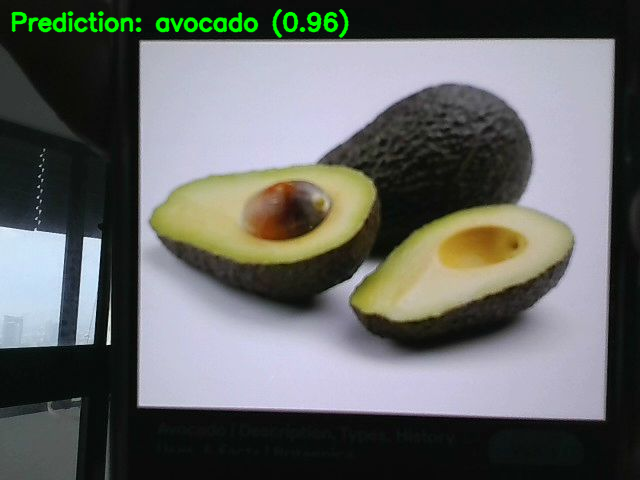

<IPython.core.display.Javascript object>

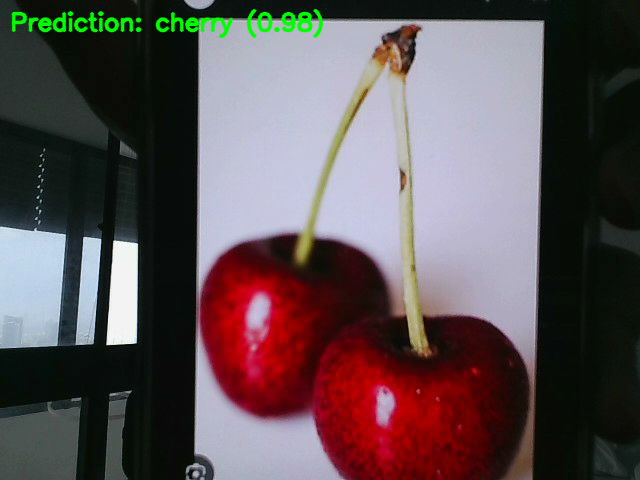

<IPython.core.display.Javascript object>

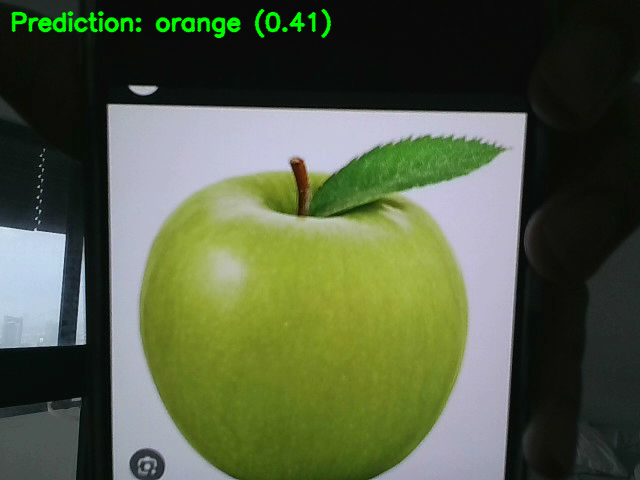


Program terminated by user.
Detection stopped.


In [20]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import tensorflow as tf
import time # Delay control

# Function to capture a single frame from the webcam
def capture_frame(quality=0.8):
    js = Javascript('''
        async function captureFrame(quality) {
            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            // Create video element and start stream
            video.srcObject = stream;
            await video.play();

            // Capture a single frame to a canvas
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            // Stop the stream and return the image data
            stream.getTracks().forEach(track => track.stop());
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js(f'captureFrame({quality})')
    binary = b64decode(data.split(',')[1])
    img_array = np.frombuffer(binary, np.uint8)
    return cv2.imdecode(img_array, cv2.IMREAD_COLOR)

# Classification
def run_classification_colab(transfer_model, labels, target_size=(128, 128)):
    print("Press 'Stop' in Colab or interrupt the kernel to stop.")
    try:
        while True:
            # Capture a frame
            frame = capture_frame()
            if frame is None:
                print("No frame captured (frame is None).")
                time.sleep(0.1)
                continue

            # Checking frames
            if not isinstance(frame, np.ndarray):
                print(f"Captured frame is not a numpy array, type: {type(frame)}. Skipping.")
                time.sleep(0.1)
                continue
            if frame.size == 0:
                print("Captured an empty numpy array (frame.size == 0). Skipping.")
                time.sleep(0.1)
                continue
            # Ensure it's a 3-channel image as expected by cv2.cvtColor(BGR2GRAY)
            if len(frame.shape) != 3 or frame.shape[2] != 3:
                print(f"Captured frame has unexpected shape {frame.shape} (expected H, W, 3). Skipping.")
                time.sleep(0.1)
                continue

            # Resizing
            resized_frame = cv2.resize(frame, target_size)

            # Normalize pixel values and add batch and channel dimensions
            input_frame = resized_frame.astype('float32') / 255.0
            input_frame = np.expand_dims(input_frame, axis=-1)  # Add channel dimension (1 for grayscale)
            input_frame = np.expand_dims(input_frame, axis=0)   # Add batch dimension

            # Make prediction
            # Explicitly cast to tf.constant to ensure TensorFlow receives a well-defined tensor
            predictions = transfer_model.predict(tf.constant(input_frame), verbose=0)[0]
            predicted_class_index = np.argmax(predictions)
            confidence = predictions[predicted_class_index]

            # Get label name from index
            predicted_label = labels[predicted_class_index]

            # Display the prediction on the original color frame
            text = f"Prediction: {predicted_label} ({confidence:.2f})"
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)

            cv2_imshow(frame)
            time.sleep(10) # Delay for each capture

    except Exception as e:
        print(f"An error occurred: {e}")
    except KeyboardInterrupt:
      print("\nProgram terminated by user.")
    finally:
        print("Detection stopped.")

# Getting classes for display
class_labels = list(train_gen.class_indices.keys())

# Run the classification in Colab
run_classification_colab(transfer_model, class_labels)
